근시나 노안인 고객을 위해 읽기 힘든 글자를 읽기 쉽게 만들어주는 서비스를 개발하게 되었다고 가정합니다. 읽기 힘든 글자를 읽기 쉽게 만들어주는 기준에서 OCR을 검증합니다. 

## 검증용 데이터셋 준비

텍스트가 기울어져있거나, 작거나, 노이즈가 심하면 읽기 힘듭니다. 따라서 세 가지 조건 각각에 맞는 이미지를 각각 2장씩 총 6장을 준비하였습니다.

In [41]:
import matplotlib.pyplot as plt
import keras_ocr
import cv2
import glob
import os
%matplotlib inline
pipeline = keras_ocr.pipeline.Pipeline()

image_urls = [
#기울임
'https://source.unsplash.com/UJij-wz7w88',
'https://source.unsplash.com/pD9oO3cRUJs',

#작은글자
'https://source.unsplash.com/udBkennKG90',
'https://source.unsplash.com/WwTsI9kPOI8',
    
#노이즈
'https://source.unsplash.com/oqStl2L5oxI',
'https://source.unsplash.com/KVihRByJR5g'
]


Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


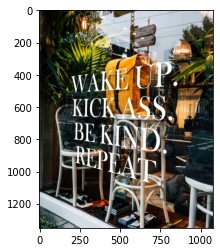

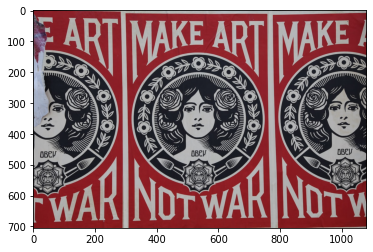

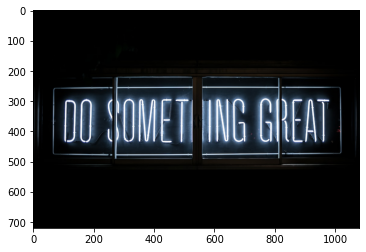

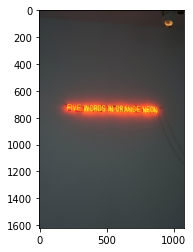

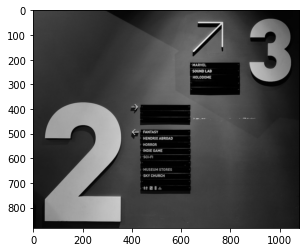

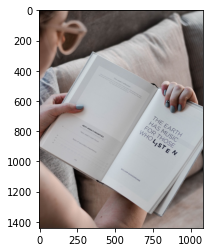

In [42]:
paths = glob.glob(os.getenv('HOME')+'/aiffel/ocr_python/project-2/*.jpg')
paths.sort()
for p in paths:
    img = cv2.imread(p)
    #cv2.resize(img, (0,0), img, 0.1, 0.1, cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()


## keras-ocr, Tesseract로 테스트 진행

먼저 keras-ocr로 테스트 하였습니다.

In [4]:
images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]


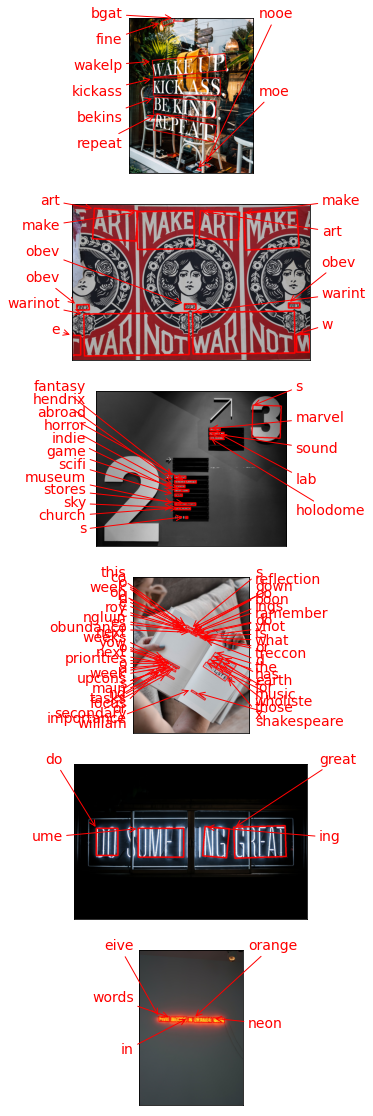

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

같은 이미지 6장을 tesseract로 테스트 하였습니다.

In [37]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    #print(dir(image))
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left, #min(left, image.width-1),
                top,  #min(top, image.height-1),
                left+width, #min(left+width, image.width-1),
                top+height  #min(top+height, image.height-1)
            ))
            print(cropped_image.size)
            if 0 in cropped_image.size:
                continue
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [31]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/project-2'
img_file_path = work_dir + '/a1.jpg'  

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/project-2/0000.png


In [32]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


Done


In [38]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/project-2'
img_file_path = work_dir + '/a2.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/project-2/0000.png
(0, 705)
Done


In [34]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/project-2'
img_file_path = work_dir + '/s1.jpg'   

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/project-2/0000.png
/aiffel/aiffel/ocr_python/project-2/0001.png
/aiffel/aiffel/ocr_python/project-2/0002.png
/aiffel/aiffel/ocr_python/project-2/0003.png
/aiffel/aiffel/ocr_python/project-2/0004.png
/aiffel/aiffel/ocr_python/project-2/0005.png
/aiffel/aiffel/ocr_python/project-2/0006.png
/aiffel/aiffel/ocr_python/project-2/0007.png
/aiffel/aiffel/ocr_python/project-2/0008.png
/aiffel/aiffel/ocr_python/project-2/0009.png
/aiffel/aiffel/ocr_python/project-2/0010.png
/aiffel/aiffel/ocr_python/project-2/0011.png
/aiffel/aiffel/ocr_python/project-2/0012.png
/aiffel/aiffel/ocr_python/project-2/0013.png
/aiffel/aiffel/ocr_python/project-2/0014.png
/aiffel/aiffel/ocr_python/project-2/0015.png
/aiffel/aiffel/ocr_python/project-2/0016.png

Telesis

| AB

3

HOLODOME

a

UL

HENDRIX ABROAD

HORROR

GAME

eee

a

MUSEUM STORES

SKY CHURCH

tas

=

V

Done


In [17]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/project-2'
img_file_path = work_dir + '/s2.jpg'   

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/project-2/0000.png
Ef '

Done


In [39]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/project-2'
img_file_path = work_dir + '/n1.jpg'   

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/project-2/0000.png
(0, 659)
Done


In [19]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/project-2'
img_file_path = work_dir + '/n2.jpg'   

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/project-2/0000.png
=

Done


## 결과 분석과 결론 제시

테스트 결과는 다음 척도를 가지고 비교합니다.   
정확도 = 맞춘 글자수/전체 글자수  
인식률 = 인지한 글자수 / 전체 글자수

keras-ocr은 전반적으로 인식률이 100%에 가깝고, 정확도도 90% 가까이 나왔습니다. 노이즈가 있을때는 정확도가 떨어지고 글자가 큰 숫자인 경우는 인식하지 못했습니다.  

tesseract는 기울어져있는 글자 판독에서는  정확도도 인식률도 낮았습니다. 가로 정렬이 잘 된 작은 글자 판독에는 정확도는 떨어지지만 tesseract도 꽤 인식률을 보입니다. 노이즈 있는 글자 판독에서는 하나도 제대로 찾아내지 못했습니다.

기울임, 작은 글씨, 노이즈라는 조건에서도 비교적 잘 인식하고 정확히 글자를 판단하는 keras-ocr이 우리 서비스에 적합하다고 판단되었습니다.

## 회고

tesseract를 이용했을 때 crop한 이미지를 저장하는 과정에서 tile cannot extend outside image 라는 에러메시지가떴습니다. crop을 할 때는 괜찮은데 저장을 할 때 오류가 뜨는 이유는 이미지의 한 변의 길이가 0이기 때문이었습니다. 한 변의 길이가 0이면 저장하지 않도록 했더니 해당 이미지에서는 검출된 텍스트가 하나도 없게 되었습니다. tesseract가 예상보다 성능이 낮은데, 더 잘 사용하는 방법이 있을 것 같아서 더 찾아보고 싶습니다.
